In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import gradio as gr


In [32]:
train_df = pd.read_csv("/content/train loan approval.csv")
test_df = pd.read_csv("/content/test loan approval.csv")

print(train_df.head())
print(train_df.info())


    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [33]:
train_df.isnull().sum()

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


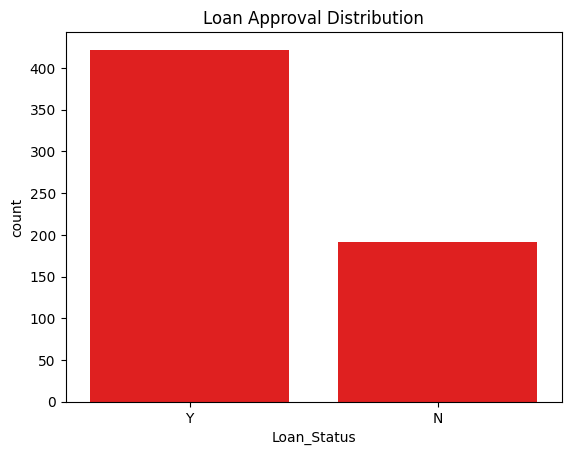

In [34]:
sns.countplot(x="Loan_Status", data=train_df, color='red')
plt.title("Loan Approval Distribution")
plt.show()

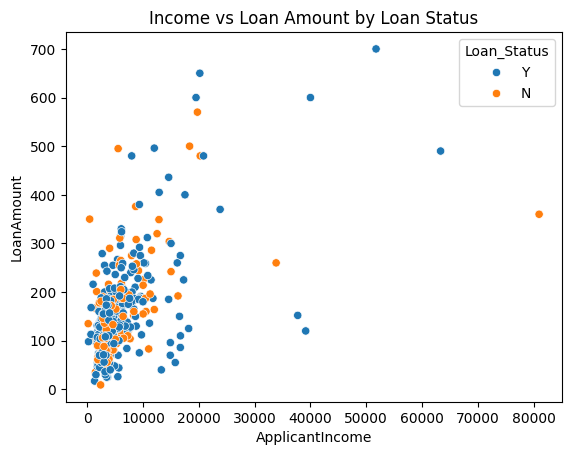

In [48]:
sns.scatterplot(x="ApplicantIncome", y="LoanAmount", hue="Loan_Status", data=train_df)
plt.title("Income vs Loan Amount by Loan Status")
plt.show()


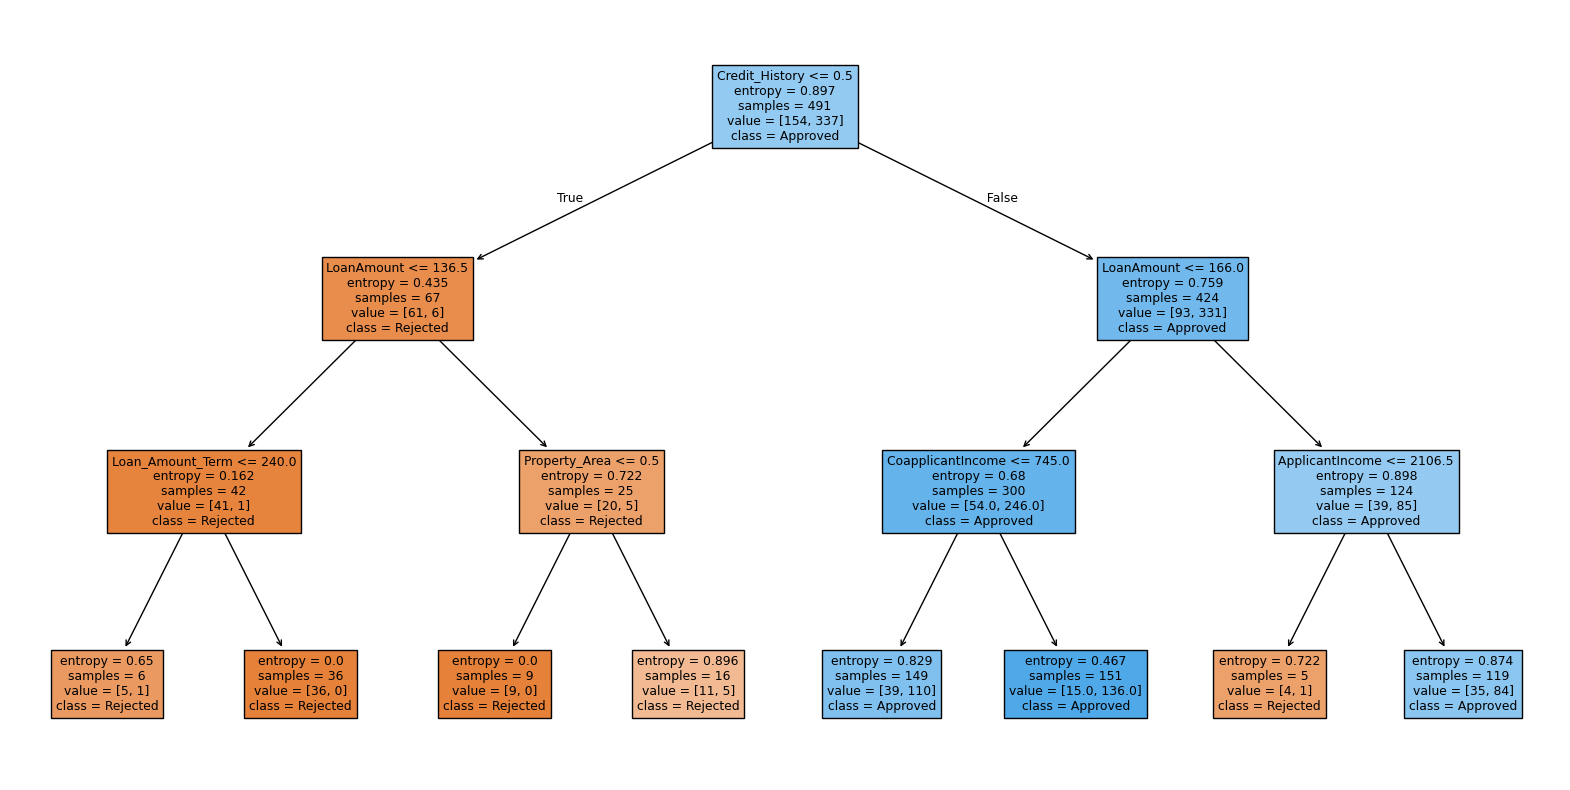

In [49]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(best_model,feature_names=X.columns,class_names=["Rejected", "Approved"],filled=True)
plt.show()


In [35]:
print("TRAIN COLUMNS:\n", train_df.columns.tolist())
print("\nTEST COLUMNS:\n", test_df.columns.tolist())


TRAIN COLUMNS:
 ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

TEST COLUMNS:
 ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']


In [36]:
for df in [train_df, test_df]:
    if "Loan_ID" in df.columns:
        df.drop(columns=["Loan_ID"], inplace=True)

In [37]:
print(train_df.columns)
print(test_df.columns)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')


In [38]:
TARGET = "Loan_Status"

cat_cols = (train_df.select_dtypes(include="object").columns.drop(TARGET))

In [39]:
print(cat_cols)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Property_Area'],
      dtype='object')


In [40]:
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    encoders[col] = le

In [41]:
X = train_df.drop("Loan_Status", axis=1)
y = train_df["Loan_Status"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [42]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)

In [43]:
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Accuracy: 0.7723577235772358
              precision    recall  f1-score   support

           N       0.61      0.71      0.66        38
           Y       0.86      0.80      0.83        85

    accuracy                           0.77       123
   macro avg       0.74      0.76      0.74       123
weighted avg       0.78      0.77      0.78       123



In [44]:
param_grid = {"max_depth": [3, 5, 7, 10, None], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4], "criterion": ["gini", "entropy"]}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [45]:
y_pred_best = best_model.predict(X_val)

print("Final Accuracy:", accuracy_score(y_val, y_pred_best))
print(confusion_matrix(y_val, y_pred_best))

Final Accuracy: 0.8455284552845529
[[21 17]
 [ 2 83]]


In [46]:
def predict_loan(Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area):
    input_data = pd.DataFrame([[Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area]], columns=X.columns)
    prediction = best_model.predict(input_data)[0]

    return "Loan Approved" if prediction == 1 else "Loan Rejected"


In [47]:
app = gr.Interface(
    fn=predict_loan,
    inputs=[
        gr.Dropdown([0,1], label="Gender (0: Female, 1: Male)"),
        gr.Dropdown([0,1], label="Married (0: No, 1: Yes)"),
        gr.Dropdown([0,1,2,3], label="Dependents"),
        gr.Dropdown([0,1], label="Education (0: Not Graduate, 1: Graduate)"),
        gr.Dropdown([0,1], label="Self Employed (0: No, 1: Yes)"),
        gr.Number(label="Applicant Income"),
        gr.Number(label="Coapplicant Income"),
        gr.Number(label="Loan Amount"),
        gr.Number(label="Loan Term"),
        gr.Dropdown([0,1], label="Credit History (0: No, 1: Yes)"),
        gr.Dropdown([0,1,2], label="Property Area (0: Rural, 1: Semiurban, 2: Urban)")
    ],
    outputs=gr.Textbox(label="Loan Status"),
    title="🏦 Loan Approval Decision System",
    description="Decision Tree based Loan Approval Prediction"
)

app.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1ae191ce4782e3ae16.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
